### Examine the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


# Read the dataset
df = pd.read_csv('waterTank_valueFlip_ctrl.csv', index_col=0, header=0, parse_dates=True)
df.index.freq = 'MS'

df.head()


,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [2]:
df.isna().sum()

Tank1WaterLevel    0
Tank2WaterLevel    0
Tank1InFlow        0
Tank2OutFlow       0
wt3_valve          0
Tank3OutFlow       0
Tank2.level        0
dtype: int64

In [3]:
len(df)

15001

### Plot the source data

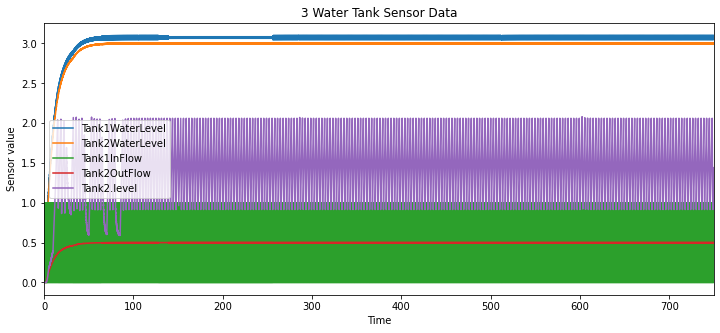

In [4]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df['Tank1WaterLevel'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Tank2WaterLevel'].plot(legend=True)
df['Tank1InFlow'].plot(legend=True)
df['Tank2OutFlow'].plot(legend=True)
# df['wt3_valve'].plot(legend=True)
# df['Tank3OutFlow'].plot(legend=True)
df['Tank2.level'].plot(legend=True)
plt.show()

In [5]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [6]:
adf_test(df['Tank1WaterLevel'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.325979e+01
p-value                 8.443583e-25
#lags                   4.200000e+01
#observations           1.495800e+04
critical value (1%)    -3.430787e+00
critical value (5%)    -2.861733e+00
critical value (10%)   -2.566873e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [7]:
# All the correlated features are stationary.
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


### Normalisation of the dataset

In [8]:
def normalise_timeseries(data):
    # Calculate the mean and standard deviation for each feature
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    
    # Normalise each feature using standard deviation
    normalised_data = (data - means) / stds
    
    return pd.DataFrame(normalised_data), means, stds

def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)


time_series_data = np.array([[1,2,3],[4,5,6],[7,8,9]])

# normalised_data, means, stds = normalise_timeseries(time_series_data)
normalised_data, means, stds = normalise_timeseries(df)
# print("---------------Original data---------------")
# print(time_series_data)
# print("---------------Normalised data---------------")
# print(normalised_data)
# print("---------------Original data---------------")
# print(denormalise_timeseries(normalised_data, means, stds))

In [9]:
df = normalised_data

In [10]:
df

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,-11.918320,-11.820661,-1.001802,-10.143714,-0.592517,-0.565458,-3.767334
0.05,-11.918321,-11.820660,-1.001802,-10.143714,-0.592517,-0.565458,-3.767334
0.10,-11.905215,-11.820660,0.998202,-10.143714,-0.592517,-0.565458,-3.767334
0.15,-11.704101,-11.785282,0.998202,-10.143714,-0.592517,-0.565458,-3.767334
0.20,-11.614902,-11.702742,-1.001802,-10.143714,-0.592517,-0.565458,-3.767334
...,...,...,...,...,...,...,...
749.80,0.241088,0.188868,-1.001802,0.181158,-0.592517,-0.565458,-0.214722
749.85,0.157189,0.194102,-1.001802,0.196210,-0.592517,-0.565458,-0.161718
749.90,0.065612,0.167090,-1.001802,0.180843,-0.592517,-0.565458,-0.082087


In [11]:
# Train Test Split
nobs = 3000
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(12001, 3000)

### VAR Model Order Selection

In [12]:
p = [1,2,3,4,5,6,7] # try with list of 7 p values
p = list(range(1,20))
aic, bic = [], []
for i in p:
    model = VAR(train)
    results = model.fit(i)
    aic.append(results.aic)
    bic.append(results.bic)
    print(f'VAR Order {i}')
    print('AIC: {}'.format(results.aic))
    print('BIC: {}'.format(results.bic))
    print()

min_aic = min(aic)
min_aic_index = aic.index(min_aic) + 1
min_bic = min(bic)
min_bic_index = bic.index(min_bic) + 1
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


VAR Order 1
AIC: -43.0806453393447
BIC: -43.04614625034377

VAR Order 2
AIC: -47.42259462796949
BIC: -47.35790417441867

VAR Order 3
AIC: -51.18092628163524
BIC: -51.08604011158816

VAR Order 4
AIC: -54.27259163068816
BIC: -54.14750539119533

VAR Order 5
AIC: -55.79442598486021
BIC: -55.639135321968666

VAR Order 6
AIC: -56.94208568031787
BIC: -56.7565862390709

VAR Order 7
AIC: -57.935372403558645
BIC: -57.71965982799545

VAR Order 8
AIC: -58.29073715689964
BIC: -58.04480709005502

VAR Order 9
AIC: -58.76387601442061
BIC: -58.48772409832467

VAR Order 10
AIC: -60.421202633943444
BIC: -60.114824509621236

VAR Order 11
AIC: -60.782177144496764
BIC: -60.44556845196801

VAR Order 12
AIC: -61.577341483177904
BIC: -61.21049786145665

VAR Order 13
AIC: -61.83433265020472
BIC: -61.437249737299055

VAR Order 14
AIC: -62.461228554224355
BIC: -62.03390198713605

VAR Order 15
AIC: -62.8555728814069
BIC: -62.39799829613113

VAR Order 16
AIC: -63.565472755241395
BIC: -63.07764578676639

VAR Order 1

In [13]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank1WaterLevel',
 'Tank2WaterLevel',
 'Tank1InFlow',
 'Tank2OutFlow',
 'wt3_valve',
 'Tank3OutFlow',
 'Tank2.level']

In [14]:
from IPython.display import Markdown as md
md("Fit the VAR( {{}} ) model".format(min_aic_index))

Fit the VAR( {} ) model

### Fit the VAR {{min_aic_index}}  model

In [15]:
min_aic_index

19

In [16]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 05, Jun, 2023
Time:                     17:48:27
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -64.8764
Nobs:                     11982.0    HQIC:                  -65.2609
Log likelihood:           274067.    FPE:                3.74338e-29
AIC:                     -65.4550    Det(Omega_mle):     3.46302e-29
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.003606         0.000231          -15.633           0.000
L1.Tank1WaterLevel          0.329067         0.010414           31.600           0.000
L1.Tank2WaterLevel        

### Predict the next 20 values

In [17]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

19

In [18]:
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,-11.918320,-11.820661,-1.001802,-10.143714,-0.592517,-0.565458,-3.767334
0.05,-11.918321,-11.820660,-1.001802,-10.143714,-0.592517,-0.565458,-3.767334
0.10,-11.905215,-11.820660,0.998202,-10.143714,-0.592517,-0.565458,-3.767334
0.15,-11.704101,-11.785282,0.998202,-10.143714,-0.592517,-0.565458,-3.767334
0.20,-11.614902,-11.702742,-1.001802,-10.143714,-0.592517,-0.565458,-3.767334


In [19]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values[-lag_order:], steps=steps)
z

array([[ 0.24091898,  0.18891537, -1.00214994,  0.18119708,  1.60853055,
         1.03797285, -1.21148314],
       [ 0.12308264,  0.18842724, -1.0095892 ,  0.19547567, -0.57779368,
         0.88309699, -1.33268364],
       [ 0.06593101,  0.16695765, -0.98280239,  0.18067559, -0.62422566,
        -0.55682023, -1.28510884],
       [ 0.18709873,  0.15044756,  1.00795445,  0.15359781, -0.6035356 ,
        -0.60351949, -1.20511309],
       [ 0.25144706,  0.16565361,  0.98889897,  0.15994291, -0.62672949,
        -0.58646994, -1.1484865 ],
       [ 0.19571609,  0.1948551 , -1.00452695,  0.19132063, -0.6221602 ,
        -0.62699831, -1.06395002],
       [ 0.12233699,  0.1882698 , -1.00094316,  0.19537511, -0.60786961,
        -0.59151098, -1.00737951],
       [ 0.10302572,  0.1555485 ,  0.99953429,  0.16853916, -0.63274169,
        -0.59882102, -0.92446773],
       [ 0.18823411,  0.15052108,  0.99901974,  0.15358604, -0.59211355,
        -0.59837763, -0.86875167],
       [ 0.27843724,  0.1776

In [20]:
test

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
600.05,0.241087,0.188867,-1.001802,0.181157,1.687716,1.033208,-1.212695
600.10,0.123358,0.188439,-1.001802,0.195506,-0.592517,0.952003,-1.342459
600.15,0.065611,0.167089,-1.001802,0.180842,-0.592517,-0.565458,-1.300704
600.20,0.186895,0.150496,0.998202,0.153725,-0.592517,-0.565458,-1.221179
600.25,0.250944,0.165479,0.998202,0.159884,-0.592517,-0.565458,-1.168294
...,...,...,...,...,...,...,...
749.80,0.241088,0.188868,-1.001802,0.181158,-0.592517,-0.565458,-0.214722
749.85,0.157189,0.194102,-1.001802,0.196210,-0.592517,-0.565458,-0.161718
749.90,0.065612,0.167090,-1.001802,0.180843,-0.592517,-0.565458,-0.082087


In [21]:
# idx = pd.date_range(start='1/1/2015', periods=12, freq='MS')
# df_forecast = pd.DataFrame(z, index=idx, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast = pd.DataFrame(z, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast[:5]

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
0,0.240919,0.188915,-1.002150,0.181197,1.608531,1.037973,-1.211483
1,0.123083,0.188427,-1.009589,0.195476,-0.577794,0.883097,-1.332684
2,0.065931,0.166958,-0.982802,0.180676,-0.624226,-0.556820,-1.285109
3,0.187099,0.150448,1.007954,0.153598,-0.603536,-0.603519,-1.205113
4,0.251447,0.165654,0.988899,0.159943,-0.626729,-0.586470,-1.148487


### Plot the results

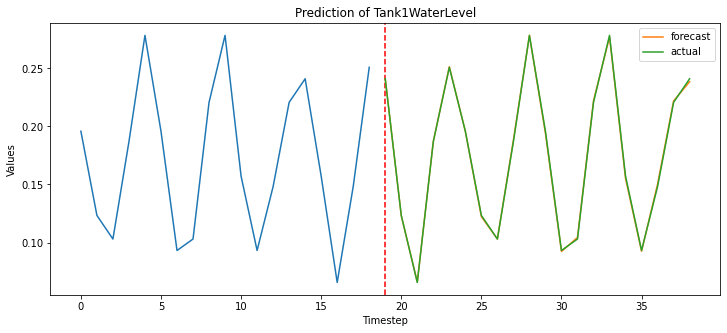

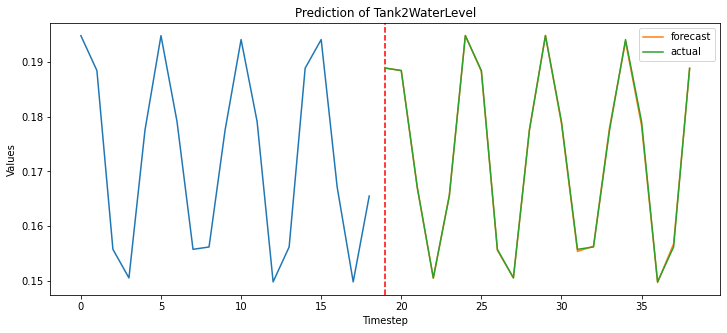

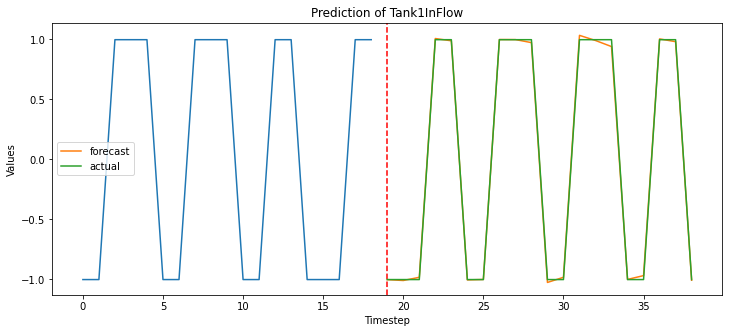

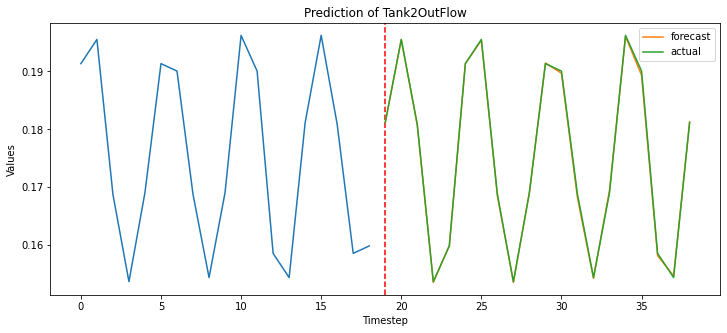

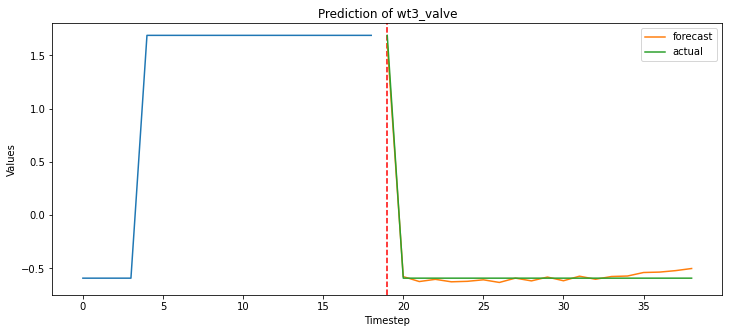

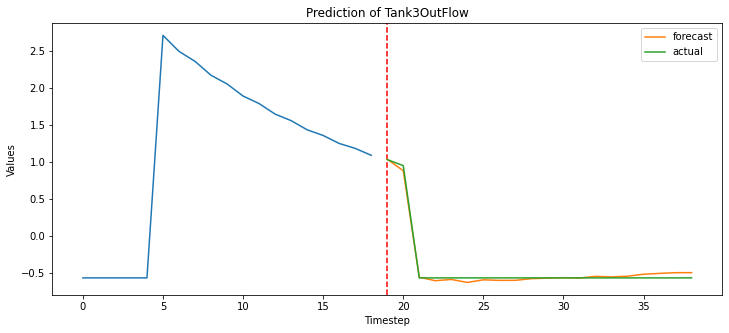

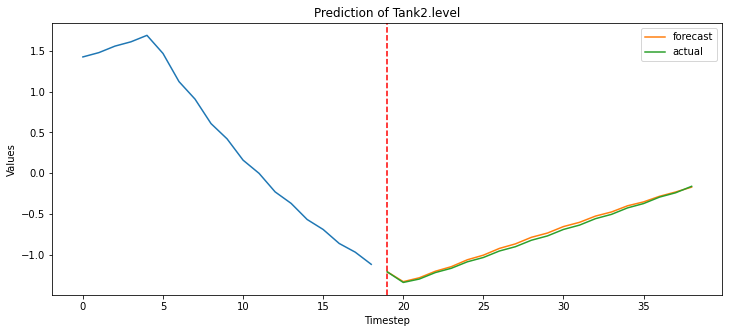

In [22]:
attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(lag_order)))
    actual = train.iloc[-lag_order:,:]
    
    index = pd.Index(list(range(lag_order, lag_order + steps)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:lag_order+1,:].set_index(index)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

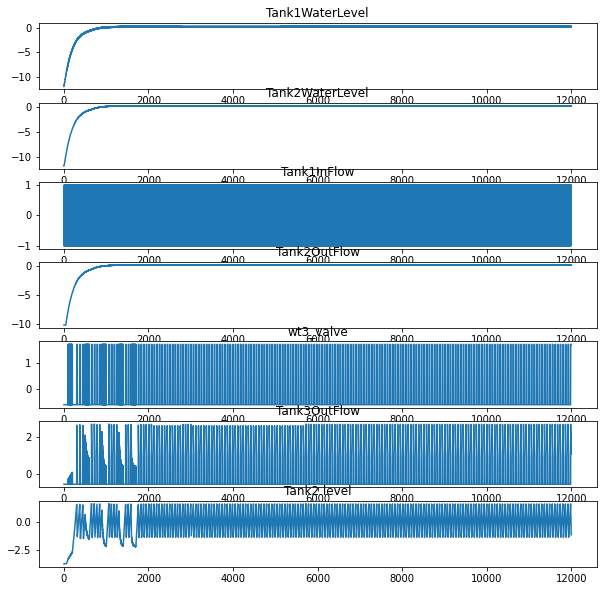

In [23]:
results.plot();

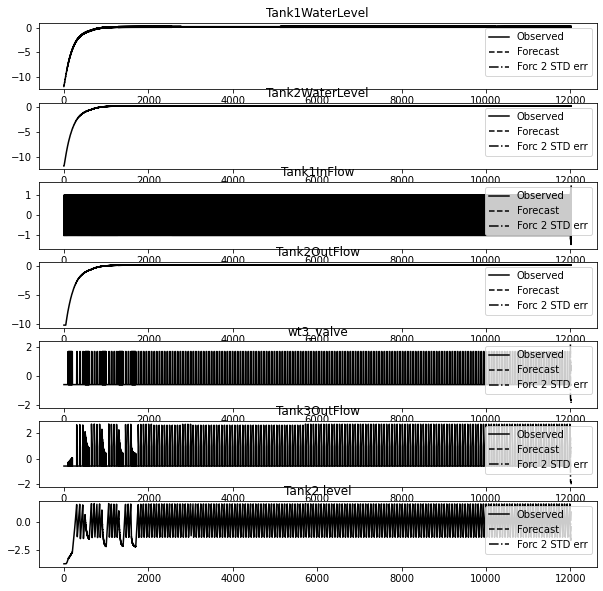

In [24]:
results.plot_forecast(20);

In [25]:
len(df_forecast)

20

In [26]:
len(df['Tank1WaterLevel'].iloc[:steps])

20

### Model Evaluation

In [27]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSE = []
for feat in attr:
    RMSE.append(rmse(df[feat].iloc[:steps], df_forecast[feat]))

print(RMSE) 

[11.61314334743235, 11.630165840418044, 1.4715358107210497, 10.318801515140864, 0.49353710857671584, 0.48452597510410084, 3.0256218255043263]


### Save the model

In [28]:
# Serialize andsave the model
import pickle
import statsmodels.api as sm
with open('var_ctrl_valueFlip.pkl', 'wb') as f:
    pickle.dump(results.params, f)
print("Model saved!")

Model saved!


### Define the faulty data

In [29]:
faulty_data = pd.read_csv('test_fault.csv', index_col=0, header=0, parse_dates=True)

faulty_data.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty = faulty_data.iloc[:-num_obs]
test_faulty = faulty_data.iloc[-num_obs:]
len(train_faulty), len(test_faulty)

(12001, 3000)

### Load the model and reconstruct VAR

In [30]:
with open('var_ctrl_valueFlip.pkl', 'rb') as f:
    params = pickle.load(f)
    
valueFlip_model = sm.tsa.VAR(train)
valueFlip_model.params = params
valueFlip_model_fit = valueFlip_model.fit(min_aic_index)

valueFlip_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 05, Jun, 2023
Time:                     17:48:31
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -64.8764
Nobs:                     11982.0    HQIC:                  -65.2609
Log likelihood:           274067.    FPE:                3.74338e-29
AIC:                     -65.4550    Det(Omega_mle):     3.46302e-29
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.003606         0.000231          -15.633           0.000
L1.Tank1WaterLevel          0.329067         0.010414           31.600           0.000
L1.Tank2WaterLevel        

### Forecast using faulty data

In [31]:
# Use the loaded model to make predictions or perform other analyses
forecast = valueFlip_model_fit.forecast(y=train_faulty.values[-lag_order:], steps=20)
# forecast = golden_model_fit.forecast(params, start=len(train), end=len(train)+10)
forecast

array([[  2.85210961,   3.09575993,  -4.9231371 ,   0.63370843,
          3.95279841,   4.05521456,  25.73009446],
       [  2.73037203,   3.05703346,  -3.77236057,   0.67612477,
          4.25626389,   7.52314926,  24.90844875],
       [  2.8971009 ,   2.94102544,   6.47904816,   0.6553676 ,
          6.83154545,   9.25972051,  23.82078298],
       [  3.15725272,   2.95626827,   5.81877705,   0.7224974 ,
          7.62349714,  12.12862801,  22.42499007],
       [  3.30237499,   3.14776939,  -6.58973342,   0.97048141,
         10.3870658 ,  14.1042171 ,  20.78293752],
       [  2.92627724,   3.13436922,  -9.28802888,   1.10767903,
          9.46538911,  16.19346067,  18.95561698],
       [  2.56466967,   2.96377054,  -0.87403345,   1.12267702,
         13.87686797,  16.89731794,  17.00655543],
       [  2.95044457,   2.93129241,   3.60747654,   1.16079875,
         12.71125628,  18.90361847,  14.87667732],
       [  3.56003587,   3.1281841 ,  -4.76324301,   1.38613686,
         16.9403

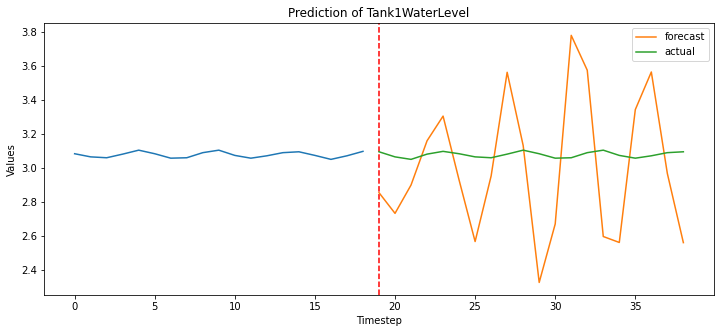

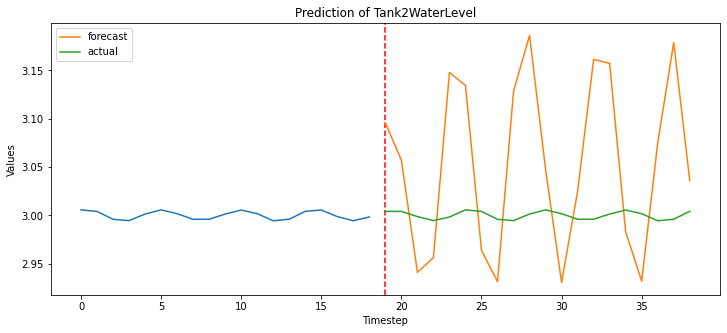

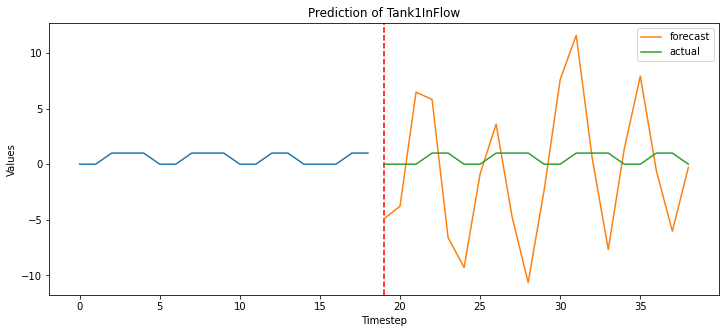

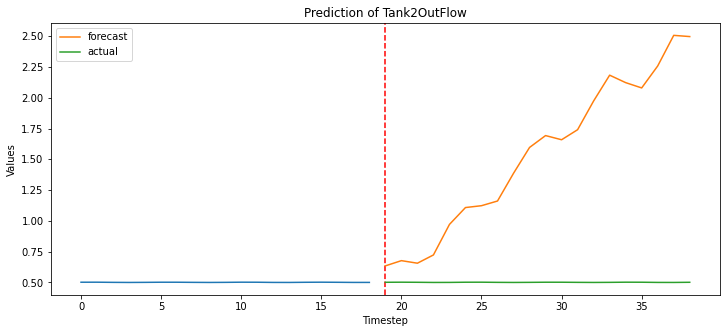

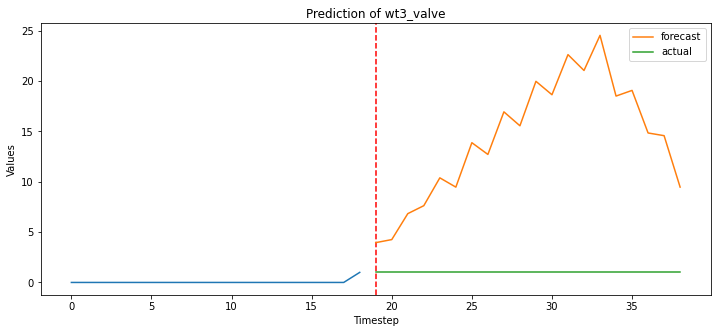

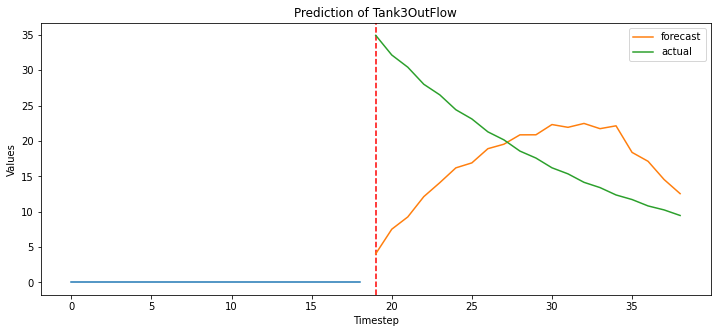

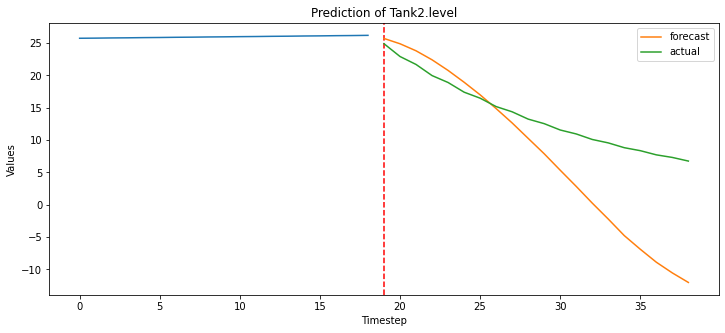

In [32]:
fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [33]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

[14.44067771177149, 14.510009477221496, 5.424366015636024, 11.697172096135962, 15.961803316233743, 18.01564748200293, 17.22884344868871]


### Increasing the duration of the faults

In [34]:
faulty_data_extend = pd.read_csv('test_extend.csv', index_col=0, header=0, parse_dates=True)

faulty_data_extend.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty_extend = faulty_data_extend.iloc[:-num_obs]
test_faulty_extend = faulty_data_extend.iloc[-num_obs:]
len(train_faulty_extend), len(test_faulty_extend)

(12001, 3000)

In [35]:
# Use the loaded model to make predictions or perform other analyses
forecast_extend = valueFlip_model_fit.forecast(y=train_faulty_extend.values[-lag_order:], steps=20)

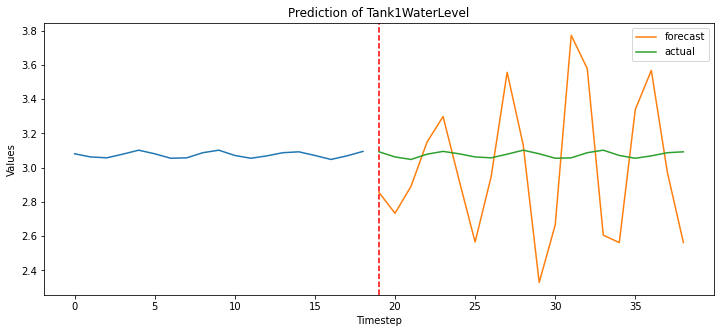

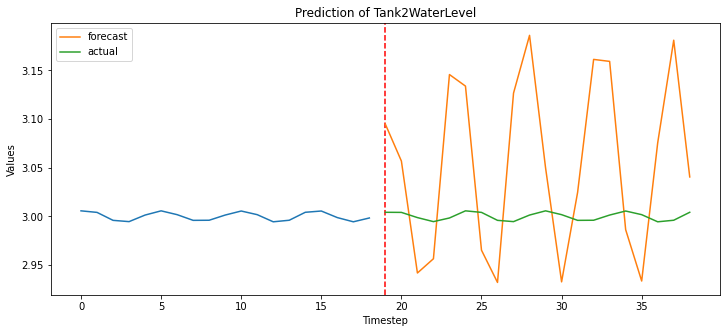

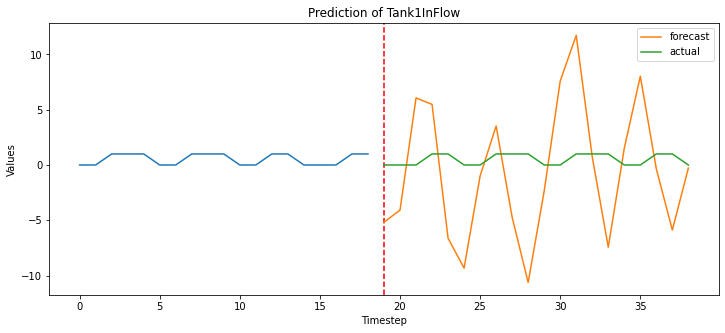

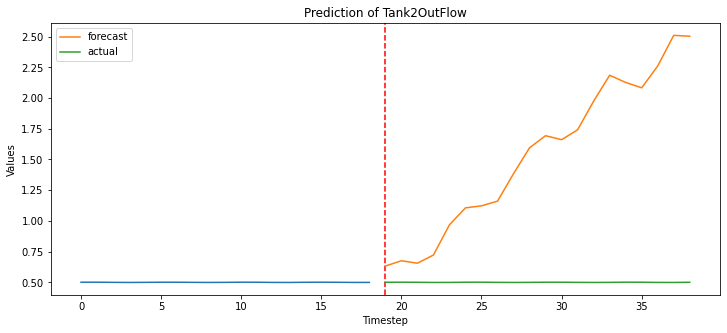

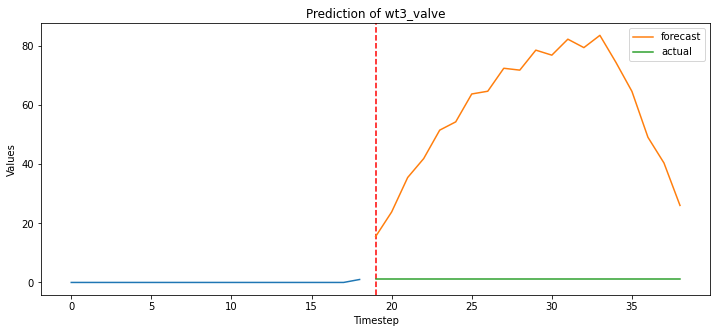

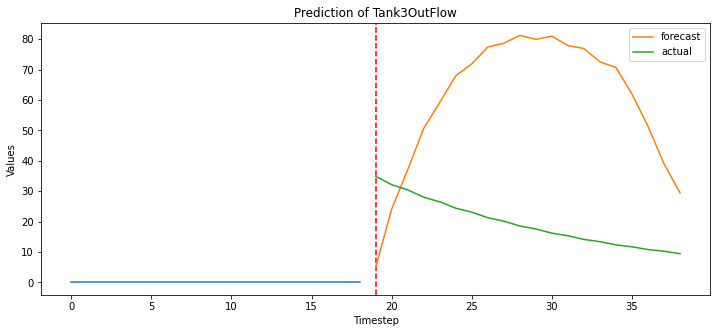

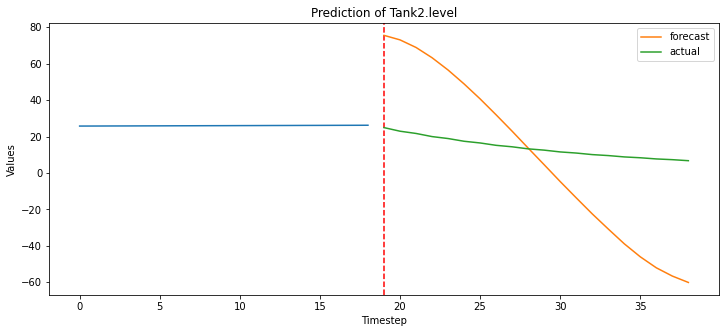

In [36]:
fault_forecast = pd.DataFrame(forecast_extend, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [37]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

[14.441999510511454, 14.510812209171448, 5.4099150555597255, 11.698135167941258, 61.66941266210124, 64.0250911090633, 47.53895507341874]


In [38]:
import keyword
print(keyword.kwlist)

['False', 'None', 'True', 'and', 'as', 'assert', 'async', 'await', 'break', 'class', 'continue', 'def', 'del', 'elif', 'else', 'except', 'finally', 'for', 'from', 'global', 'if', 'import', 'in', 'is', 'lambda', 'nonlocal', 'not', 'or', 'pass', 'raise', 'return', 'try', 'while', 'with', 'yield']
